<a href="https://colab.research.google.com/github/aminabedi/ENEL645W21-Assignemnt2/blob/fcn-maya/enel645assignment02team_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 02 - CIFAR10 Image Classification

In this assignment your team will design a fully connected neural network and a convolutional neural network (CNN) models for classifiying the CIFAR10 image dataset. The deliverables for the assignment are:

1. This jupyter-notebook completed with your solution. I expect you to try different configurations (models, train/validtion split, etc.), but for your submission, leave just the best fully connected and the best CNN models.
    - Name the notebook as enel645__assignment02__team_(team number).ipynb
2. The weights of your best fully connected neural network model and your best CNN model 
    - Name the weights files as team__(team number)__FCN.h5 (fully connected model) and team__(team number)__CNN.h5 (CNN model)

Submit the three files (notebook + models' weights) to your dropbox in the course D2L page.
    
We will be using the CIFAR10 dataset. The dataset alerady comes with a test set and you shouldn't change it. It is up to you to determine how to split your development set into training and validation sets. Use variable names consistent with the variables pre-filled in this document.


You are free to add extra cells of text and code to this notebook.

At the end of the notebook, please include a short description of what each team member did in the assignment. Also include the consensus score between 0 and 3 to each team member. This score will be used to adjust the final 
grade of each student. Students developing the project individually do not need this description and score.

You are being assessed based on (more details in the rubric):

1. Code execution - 20% 
2. Clarity of the code (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 30% 
4. Accuracy of the models  - 30%


In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import sys

## 1. Load your data

In [2]:
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

print(X_dev.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


## 2. Explore your data 

Showing 10 samples from dev set

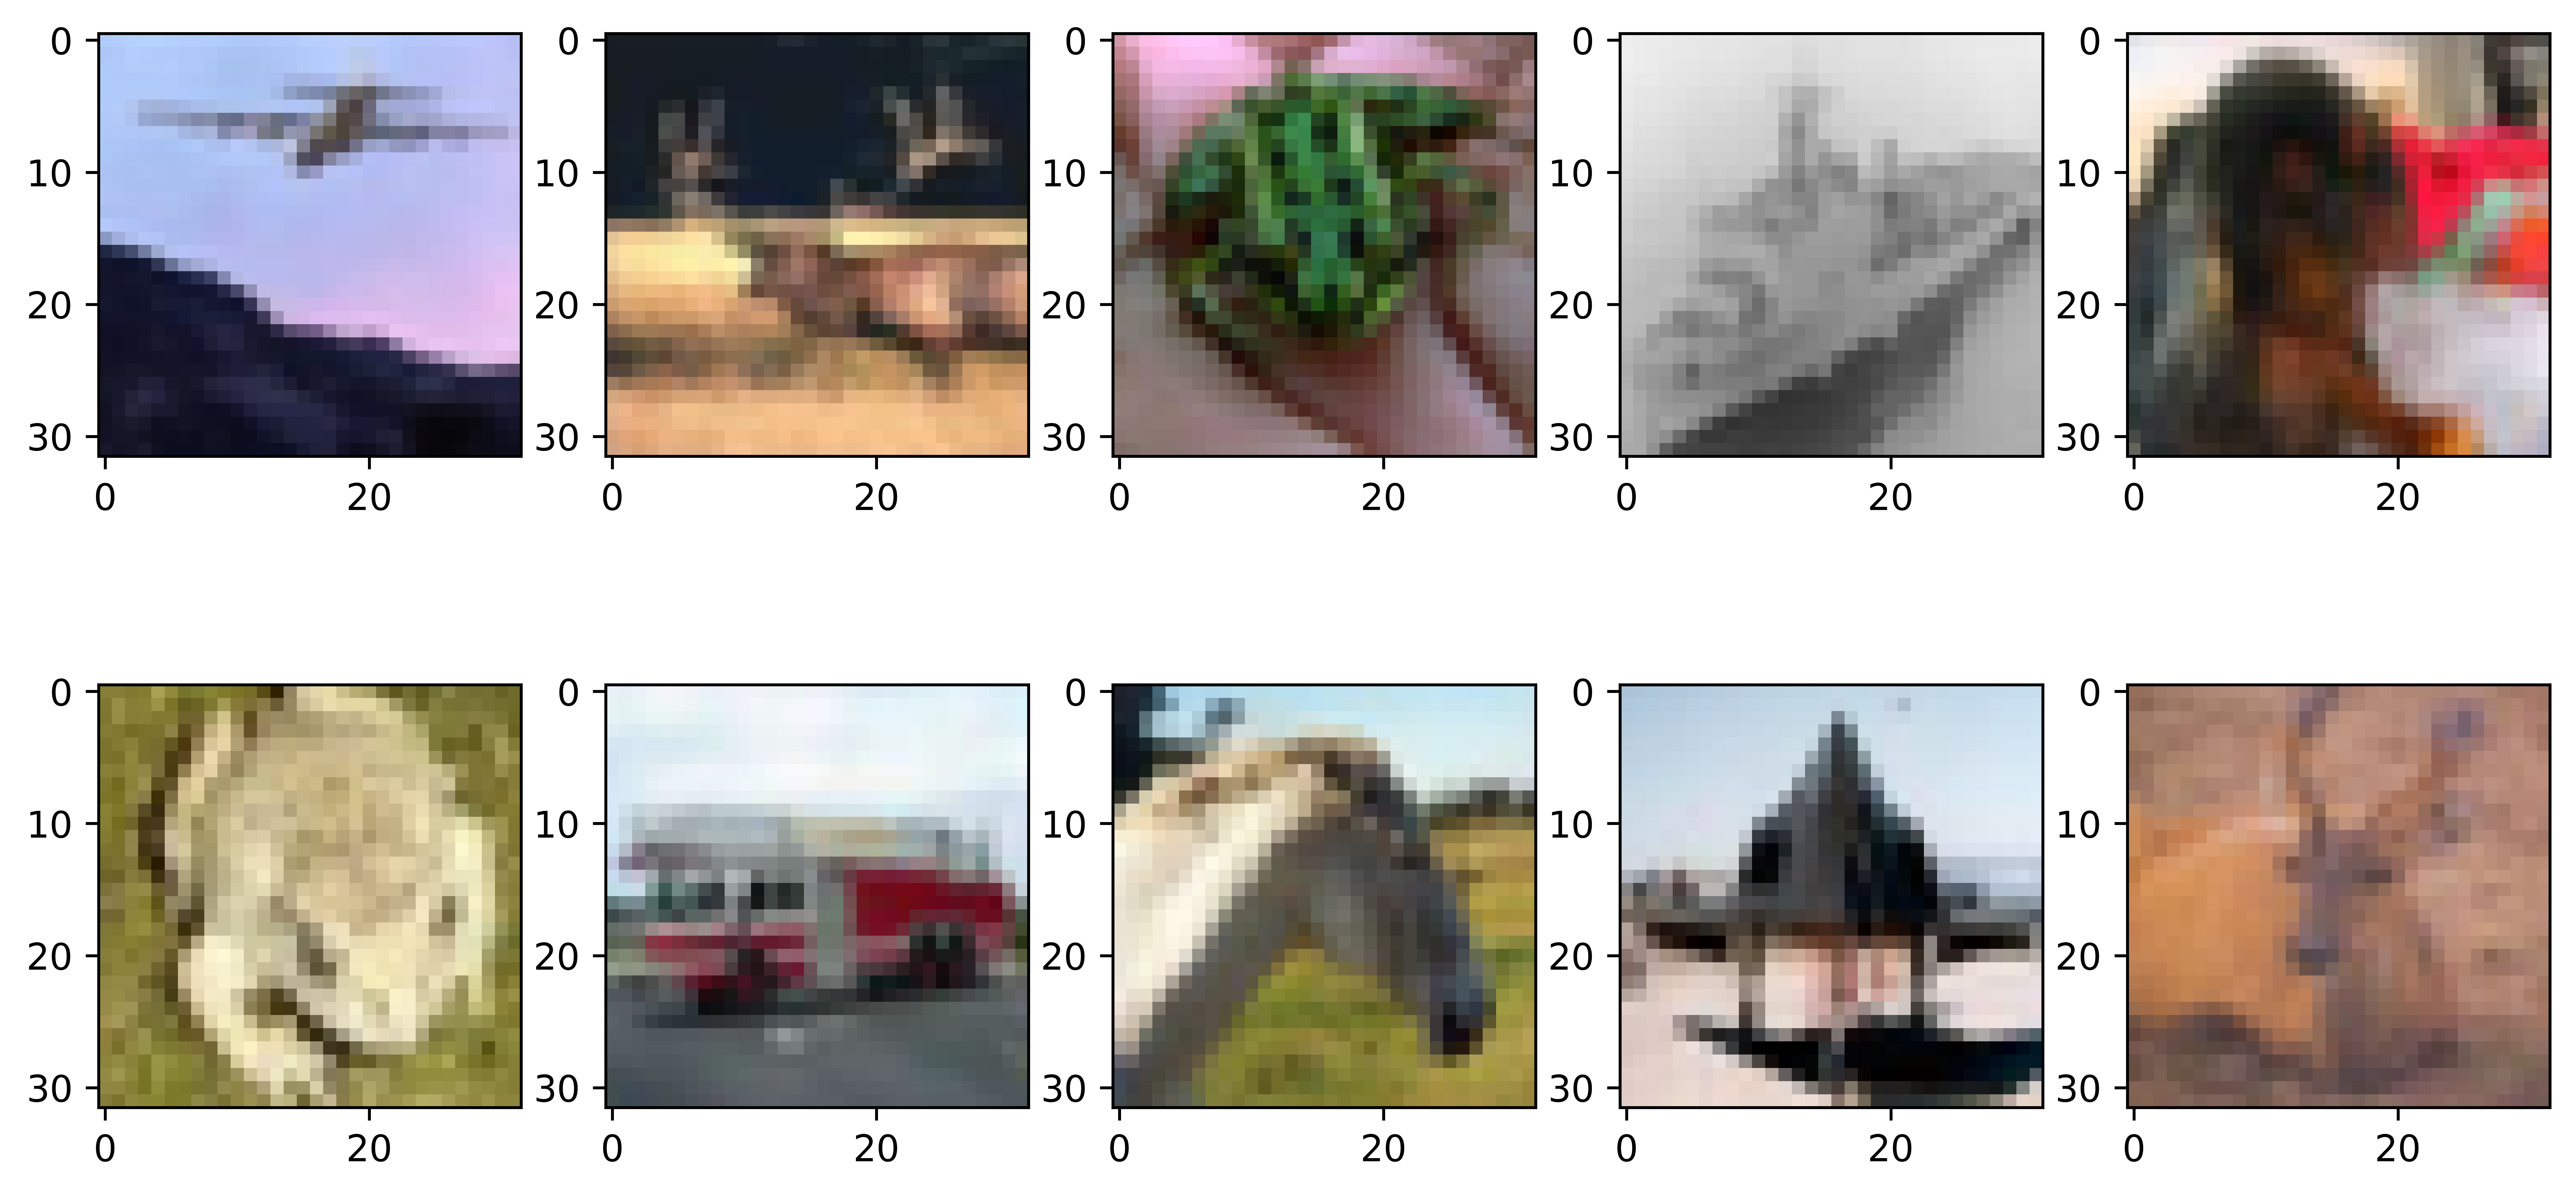

In [3]:
plt.figure(figsize=(12, 6), dpi=1000)
indexes = np.arange(len(X_dev))
np.random.shuffle(indexes)
for idx in range(10):
  plt.subplot(2, 5, idx + 1)
  plt.imshow(X_dev[indexes[idx]])
plt.show()

#Splitting dev set into train/val set

In [4]:
splitter = int(len(X_dev) * .8) #= splitting point of train/val set

X_train = X_dev[indexes[:splitter]]
Y_train = Y_dev[indexes[:splitter]]

X_val = X_dev[indexes[splitter:]]
Y_val = Y_dev[indexes[splitter:]]

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)

X_train: (40000, 32, 32, 3)
X_val: (10000, 32, 32, 3)


## 3. Represent your labels using one hot encoding

In [5]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)
Y_test_oh = tf.keras.utils.to_categorical(Y_test)

print("Y_train",  Y_train[:3])
print("Y_train_oh:",  Y_train_oh[:3])
print("Y_val",  Y_val[:3])
print("Y_val_oh:",  Y_val_oh[:3])
print("Y_test",  Y_test[:3])
print("Y_test_oh:",  Y_test_oh[:3])


#Scaling outputs , we are doing this in order to prevent double scaling.
X_train_sc = X_train
X_val_sc = X_val
X_test_sc = X_test


Y_train [[0]
 [4]
 [6]]
Y_train_oh: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Y_val [[5]
 [0]
 [7]]
Y_val_oh: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Y_test [[3]
 [8]
 [8]]
Y_test_oh: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


## 4. Data scaling and Data augmentation

In [6]:
# Experiment with different data scaling methods

scaling_mode = 2  #= 0: disabled, 1: min-max normalization, 2: standardization

X_train = X_train_sc 
X_val = X_val_sc 
X_test = X_test_sc 

if scaling_mode == 1: 
  x_train_min = X_train.min()
  x_train_max = X_train.max()
  X_train = ( X_train - x_train_min ) / (x_train_max - x_train_min)
  x_val_min = X_val.min()
  x_val_max = X_val.max()
  X_val = ( X_val - x_val_min ) / (x_val_max - x_val_min)
  x_test_min = X_test.min()
  x_test_max = X_test.max()
  X_test = ( X_test - x_test_min ) / (x_test_max - x_test_min)
elif scaling_mode == 2:
  x_train_mean = X_train.mean()
  x_train_std = X_train.std()
  print(x_train_mean, x_train_std)
  X_train = ( X_train - x_train_mean ) / x_train_std
  X_val = ( X_val - x_train_mean ) / x_train_std
  X_test = ( X_test - x_train_mean ) / x_train_std



120.7359559733073 64.1327617079631


In [7]:
# Create your data augmentation object to improve training
# set your batch size to 32 
# az the images don't have good quality, we have sat the zoom range quit small.
batch_size = 32
gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":50,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.1, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'nearest',\
               "cval": 0}

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train,Y_train_oh,batch_size = batch_size)
val_flow = val_gen.flow(X_val,Y_val_oh,batch_size = batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

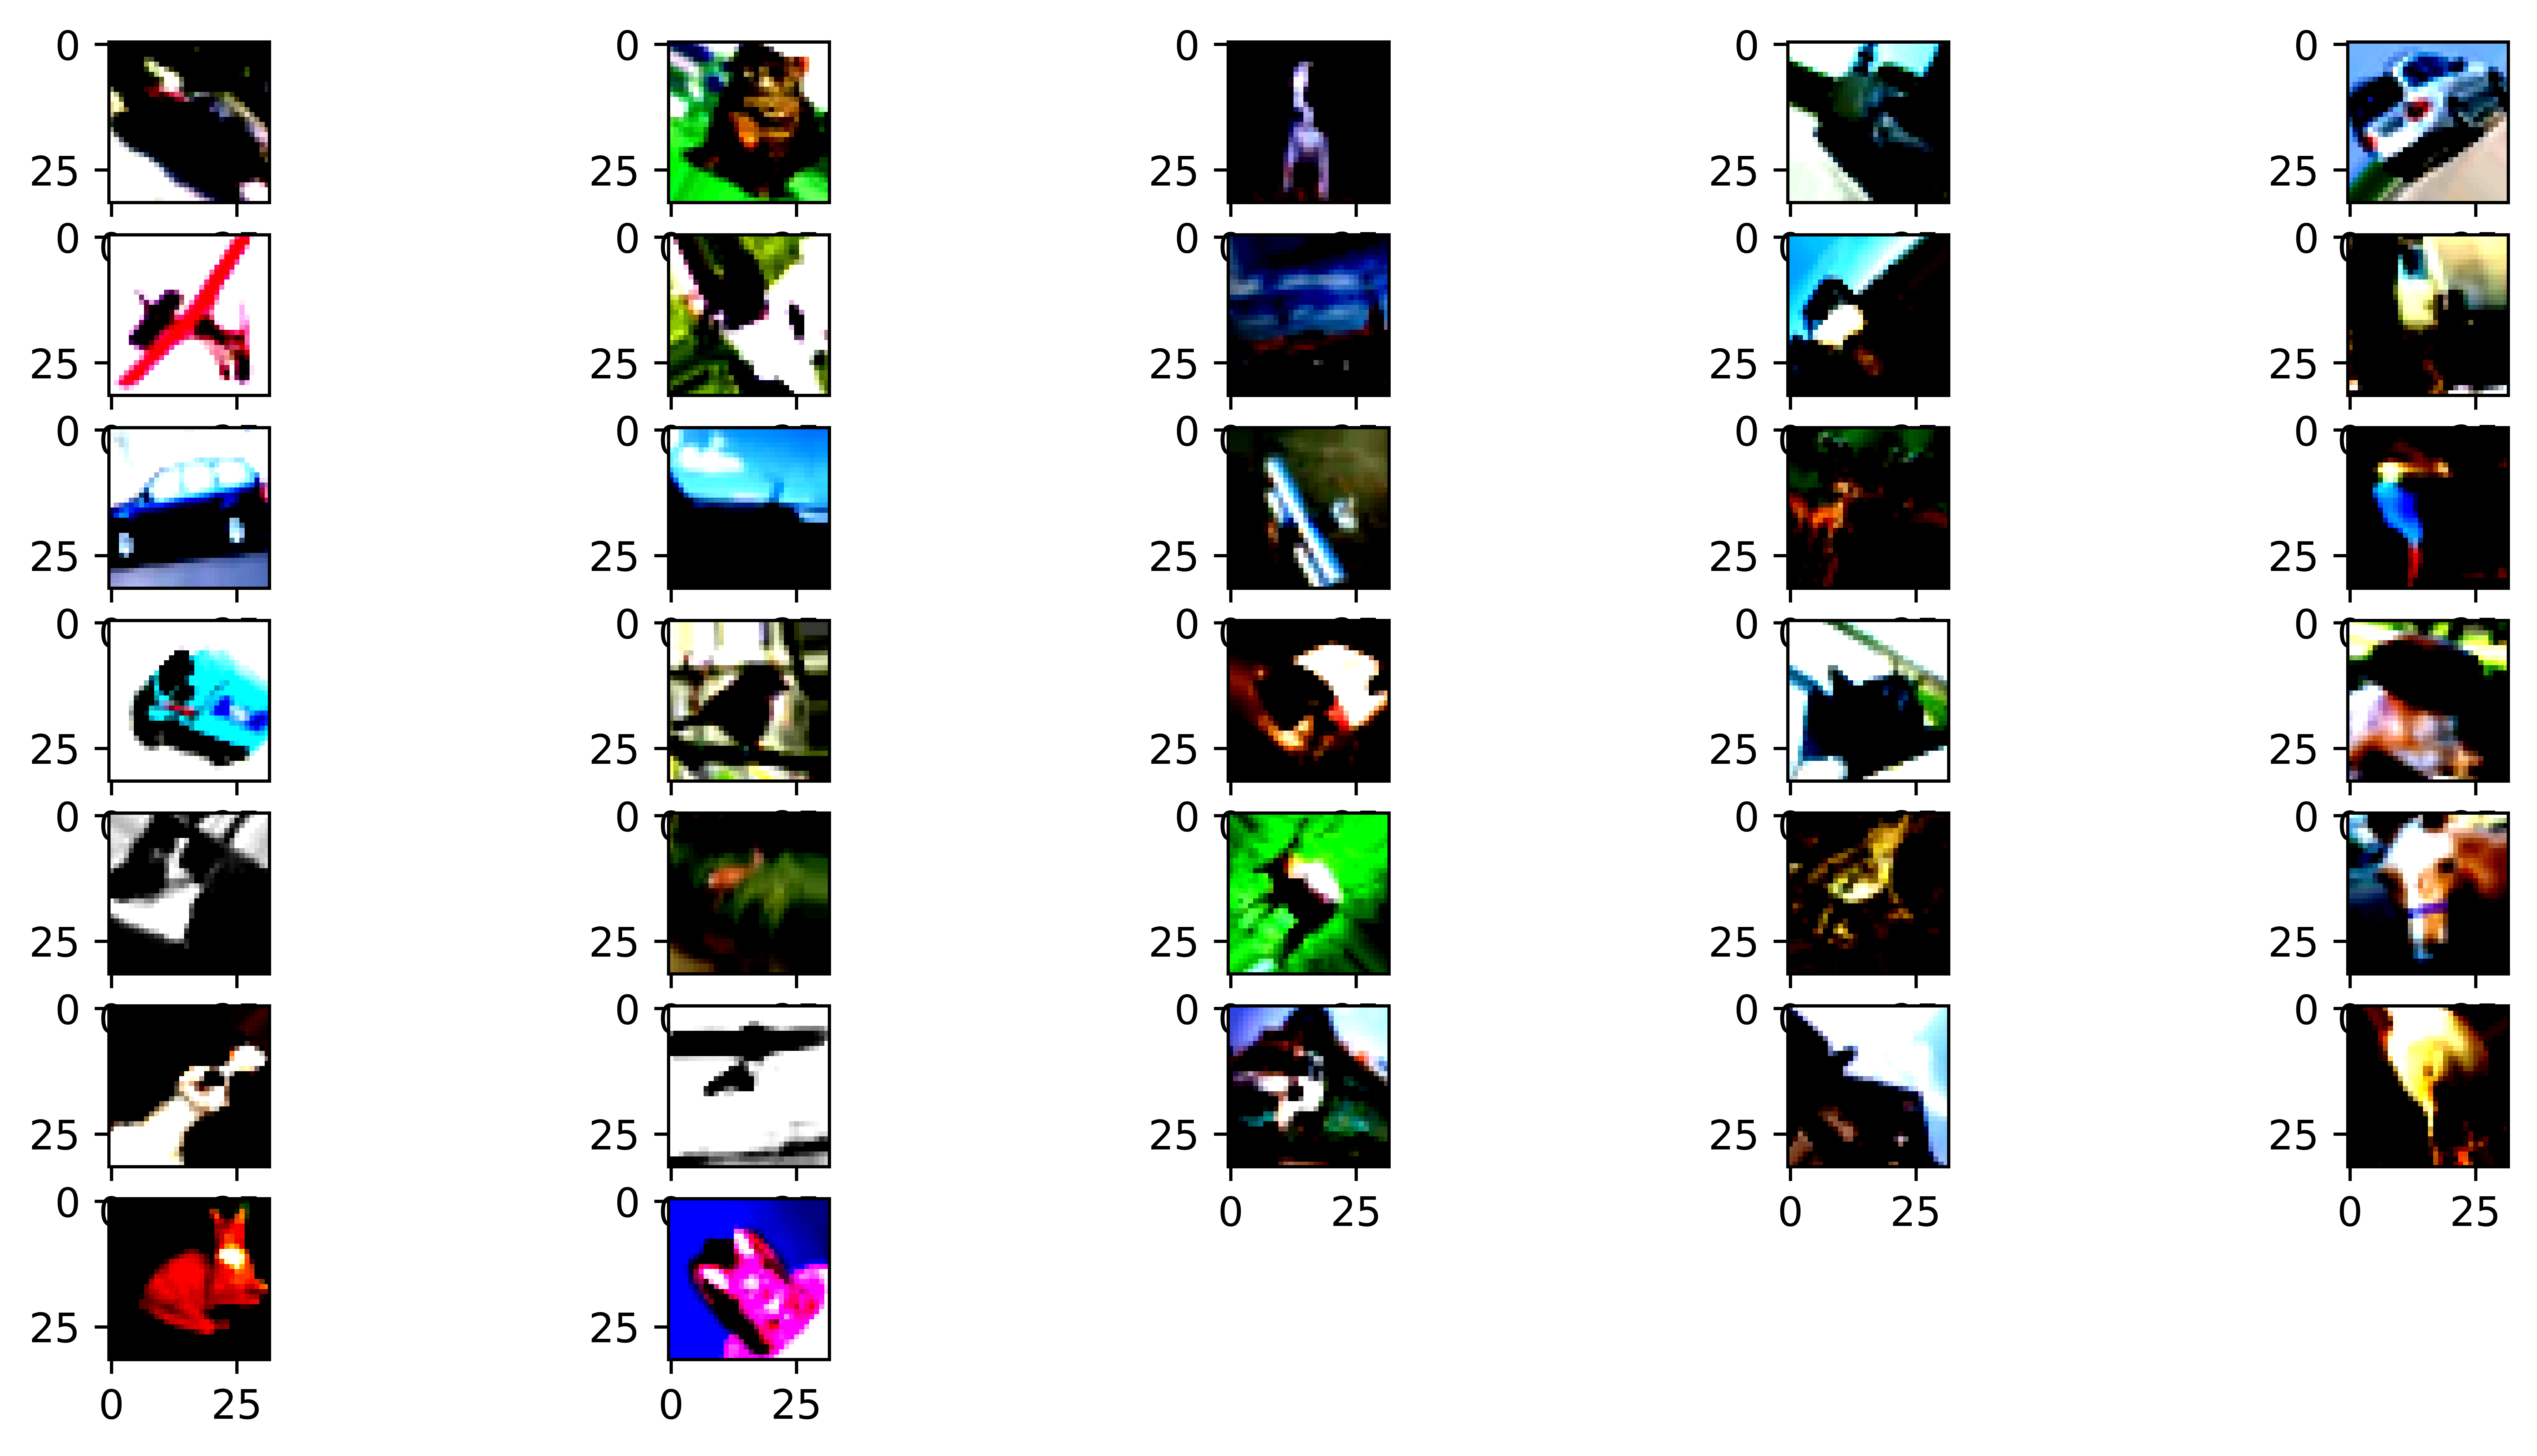

In [8]:
#Displaying some of the imgaes from the development set

plt.figure(figsize=(12, 6), dpi=1000)
Xbatch,Ybatch = train_flow.__getitem__(1)
Xbatch_min = Xbatch.min(axis=1, keepdims=True)
Xbatch_max = Xbatch.max(axis=1, keepdims=True)

for ii in range(batch_size):
    plt.subplot(7,5,ii+1)
    plt.imshow(Xbatch[ii].reshape(32, 32, 3), cmap=plt.get_cmap('gray'))
               
               
plt.show()






## Fully Connected Model

## 5. Define your  model, cost function, optimizer, learning rate

In [10]:
#Defining and compiling the fully-connected model on augmented data 
#Five hidden layers plus one dropout layer after layer 5. 
#The hidden layers before dropout layers include the following number of neurons: 2000, 1000, 500, 250, 125
#"RELU" function was used in the hidden layers , while "softmax" was used in the output layer.
#The loss is categorical cross-entropy, while accuracy was listed as a metric
#learning rate is 1e-4 
def my_model_fully_connected(ishape = (32,32,3),k = 10, lr = 1e-4):
    model_input = tf.keras.layers.Input(shape = ishape)
    model_input_flatten = tf.keras.layers.Flatten()(model_input)
    l1 = tf.keras.layers.Dense(2000,activation = 'relu')(model_input_flatten)
    l2 = tf.keras.layers.Dense(1000,activation = 'relu')(l1)  
    l3= tf.keras.layers.Dense(500,activation = 'relu')(l2)
    l4= tf.keras.layers.Dense(250,activation = 'relu')(l3) 
    l5= tf.keras.layers.Dense(125,activation = 'relu')(l4)
    l5_drop = tf.keras.layers.Dropout(0.25)(l5)
    out= tf.keras.layers.Dense(k,activation = 'softmax')(l5_drop)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model
model = my_model_fully_connected()
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 2000)              6146000   
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_4 (Dense)              (None, 125)               31375 

## 6. Define your callbacks (save your model, patience, etc.)

In [11]:
#Defining callbacks. 
#The weights of the best model are saved.
#Learning rate is halfed after each 10 epochs
#validation loss is monitored for improvement 
#Early stopping was implemented when the loss is not improving in 20 epochs.
model_name_fcn = "team_22_FCN.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_fcn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 7. Train your model

In [ ]:
#Model is trained for 100 epochs
#Progress bar to be shown with the number of training epoch.
#Augumented data was used for the validation dataset 
#Using the callbacks defined in the previous cell
model.fit(train_flow,epochs = 100, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Epoch 1/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.9941 - accuracy: 0.2795 - val_loss: 1.7863 - val_accuracy: 0.3758
Epoch 2/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.7871 - accuracy: 0.3643 - val_loss: 1.7341 - val_accuracy: 0.3868
Epoch 3/100
1250/1250 [==============================] - 14s 11ms/step - loss: 1.7328 - accuracy: 0.3854 - val_loss: 1.6787 - val_accuracy: 0.4136
Epoch 4/100
1250/1250 [==============================] - 14s 12ms/step - loss: 1.6912 - accuracy: 0.4025 - val_loss: 1.6713 - val_accuracy: 0.4170
Epoch 5/100
1250/1250 [==============================] - 14s 12ms/step - loss: 1.6702 - accuracy: 0.4087 - val_loss: 1.6348 - val_accuracy: 0.4159
Epoch 6/100
1250/1250 [==============================] - 14s 12ms/step - loss: 1.6526 - accuracy: 0.4102 - val_loss: 1.6005 - val_accuracy: 0.4424
Epoch 7/100
1250/1250 [==============================] - 14s 12ms/step - loss: 1.6154 - accuracy: 0.4322 - val_loss: 1

## 8. Test your model

313/313 [==============================] - 3s 9ms/step - loss: 1.2305 - accuracy: 0.5711
90000000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

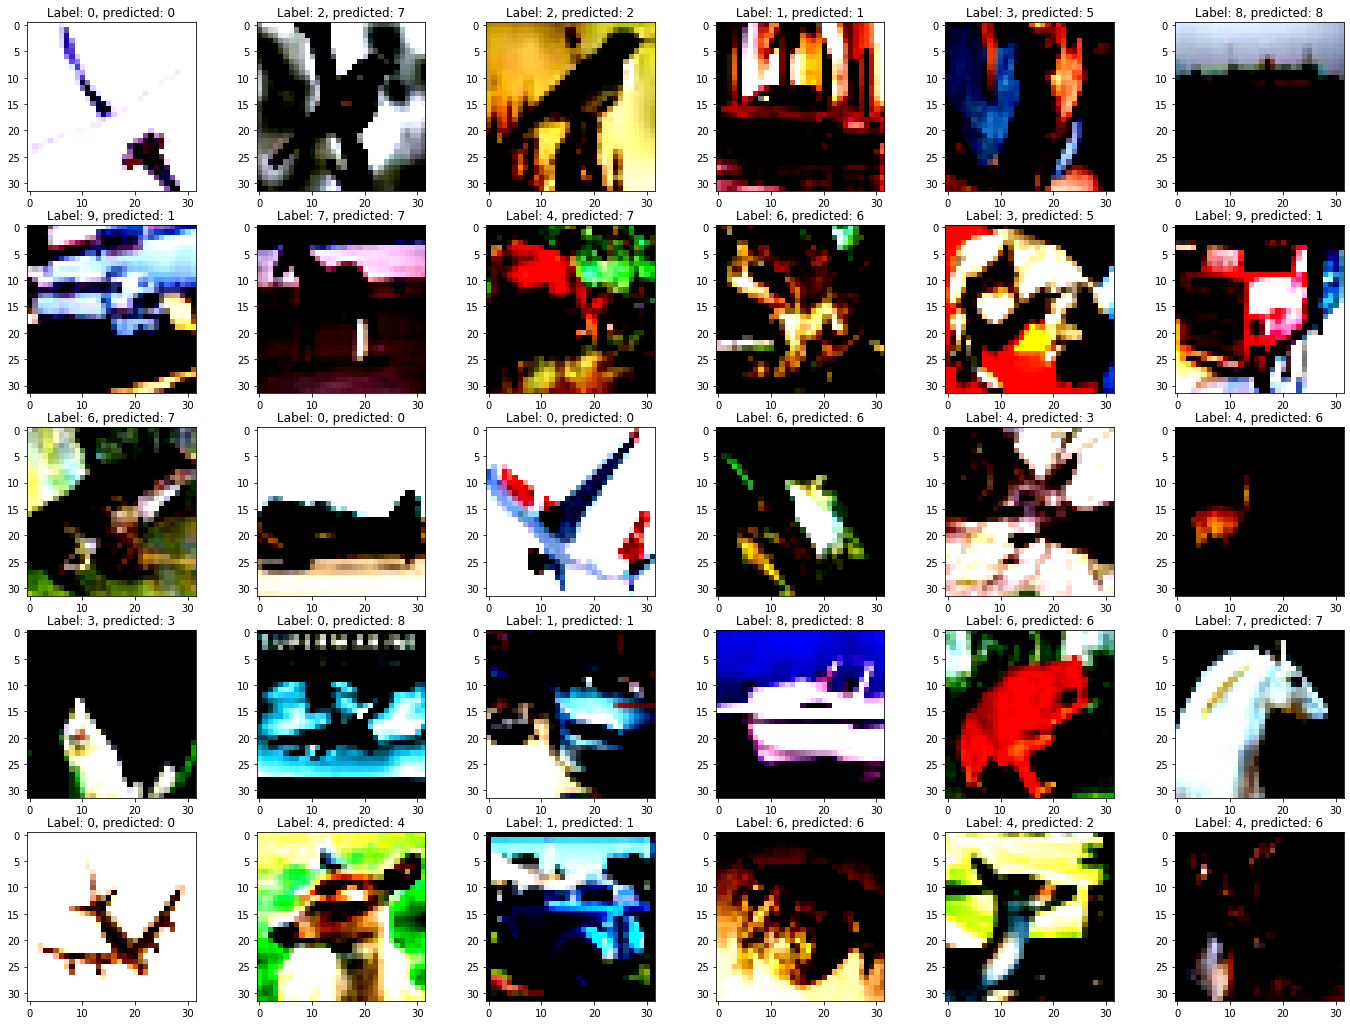

In [12]:
#testing the model on the provided test set
model.load_weights('team_22_FCN.h5')
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set 
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

## Convolutional Model

## 5. Define your  model, cost function, optimizer, learning rate

In [13]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_cnn(ishape = (32,32,3), k = 10, lr = 1e-3):
    model_input = tf.keras.layers.Input(shape= ishape)
    l1 = tf.keras.layers.Conv2D(192, (3,3), padding = 'same', activation= 'relu')(model_input)
    l2 = tf.keras.layers.Conv2D(192, (3,3), padding = 'same', activation= 'relu')(l1)
    l2_drop = tf.keras.layers.Dropout(0.25)(l2)
    l3 = tf.keras.layers.MaxPool2D((2,2))(l2_drop)
    l4 = tf.keras.layers.Conv2D(384, (3,3), padding = 'same', activation='relu')(l3)
    l5 = tf.keras.layers.Conv2D(384, (3,3), padding = 'same', activation='relu')(l4)
    l5_drop = tf.keras.layers.Dropout(0.25)(l5)
    l6 = tf.keras.layers.MaxPool2D((2,2))(l5_drop)
    flat = tf.keras.layers.Flatten()(l6)
    out = tf.keras.layers.Dense(k, activation= 'softmax')(flat)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr), loss = 'categorical_crossentropy', metrics= ["accuracy"])
    return model
model = my_model_cnn()
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 192)       5376      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 192)       331968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 192)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 192)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 384)       663936    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 384)       1327

## 6. Define your callbacks (save your model, patience, etc.)

In [14]:
model = my_model_cnn()
print(model.summary())



model_name_cnn = "team_22_FCN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_cnn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 192)       5376      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 192)       331968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 192)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 192)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 384)       663936    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 384)       1327

## 7. Train your model

In [ ]:
# train your model - decide for how many epochs
#with data augmentation
model.fit(train_flow,batch_size = 32, epochs = 150, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

#without data augmentation
#model.fit(X_train,Y_train_oh,batch_size = 32, epochs = 150, \
          #verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,Y_val_oh))

## 8. Test your model

In [18]:
model.load_weights('team_22_CNN.h5')
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()                                                                                                      

OSError: Unable to open file (unable to open file: name = 'team_22_CNN.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

##  Team members participtaion
(include the description of what each team member did and the consensus score for each team member)

- **Arya Stark** helped design the model and write the code for fully connected model (**score 3**)
- **Luke Skywalker** helped design helped to implement the data augmentation module (**score 3**)
- ...